# CIFAR hash retrieval

In [1]:
import numpy as np
np.random.seed(2017)
import tensorflow as tf
tf.set_random_seed(0)
from six.moves import cPickle as pickle
from IPython.display import display, Image
import os
import matplotlib.pyplot as plt
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline
import net_utils
tf.test.gpu_device_name()

'/device:GPU:0'

['train_neg', 'test_batch', 'batches.meta', 'train_pos', 'train_ref', 'data_batch_3', 'readme.html', 'models', 'data_batch_2', 'data_batch_1', 'data_batch_5', 'data_batch_4']


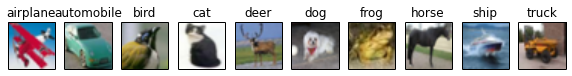

In [2]:
num_class = 10
cifar_path = 'cifar_dataset'
batch_paths = os.listdir(cifar_path)
train_data = np.ndarray(shape=(50000, 32, 32, 3), dtype=float)
train_labels_int = np.ndarray(shape=(50000), dtype=int)
train_labels = np.ndarray(shape=(50000), dtype=float)
test_data = np.ndarray(shape=(10000, 32, 32, 3), dtype=float)
test_labels_int = np.ndarray(shape=(10000), dtype=int)
test_labels = np.ndarray(shape=(10000), dtype=float)
batch_size = 10000
image_size = 32
num_channels = 3

with open(os.path.join(cifar_path, 'batches.meta'), "rb") as f:
    meta = pickle.load(f)
    class_names = meta['label_names']

print batch_paths
with open(os.path.join(cifar_path, 'test_batch'), "rb") as f:
    dict = pickle.load(f)
    raw_images = dict['data']
    norm_images = np.array(raw_images, np.float32) / 255.0
    norm_images = norm_images.reshape(-1, num_channels, image_size, image_size)
    norm_images = norm_images.transpose([0, 2, 3, 1])
    test_data = norm_images
    test_labels_int[:] = dict['labels']

offset = 0
for pf in batch_paths:
    if 'data' in pf:
        with open(os.path.join(cifar_path, pf), "rb") as f:
            dict = pickle.load(f)
            raw_images = dict['data']
            norm_images = np.array(raw_images, np.float32) / 255.0
            norm_images = norm_images.reshape(-1, num_channels, image_size, image_size)
            # Convert to TensorFlow format N,H,W,C
            norm_images = norm_images.transpose([0, 2, 3, 1])
            train_data[offset:offset + batch_size, :, :, :] = norm_images
            train_labels_int[offset:offset + batch_size] = dict['labels']
            offset += batch_size


#prepare test data
test_retrieval_data = np.ndarray(shape=(1000,32,32,3), dtype=np.float32)
test_retrieval_labels = np.ndarray(shape=(1000), dtype=np.uint8)
ind = 0
for i in range(num_class):
  class_ind = np.where(test_labels_int == i)
  class_imgs = np.squeeze(test_data[class_ind,:,:,:])
  rand_sample = np.random.permutation(class_imgs.shape[0])[0:100]
  test_retrieval_data[ind:ind+100,:,:,:] = class_imgs[rand_sample,:,:,:]
  test_retrieval_labels[ind:ind+100] = i
  ind +=100
    
fig = plt.figure(figsize=(10,10))

for c in range(num_class):
    ax = fig.add_subplot(1, 10, c + 1)
    idx = np.where(test_retrieval_labels ==c )[0]
    img_num = np.random.randint(len(idx))
    im = test_retrieval_data[idx[img_num],:,:,:]
    ax.set_title(class_names[c])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(im)
        
plt.show()


In [20]:
# convert labels to one-hot for CNN
train_labels = (np.arange(num_class) == train_labels_int[:, None]).astype(np.float32)
test_labels = (np.arange(num_class) == test_labels_int[:, None]).astype(np.float32)
batch_size = 128
fsize = 3

tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():
    tf.set_random_seed(1234)

    tf_train_data = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_class))
    tf_test_data = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    tf_test_labels = tf.placeholder(tf.float32, shape=(None, num_class))
    keep_prob = tf.placeholder("float")
    keep_prob2 = tf.placeholder("float")
    mode = tf.placeholder("string")


    def model(data, reuse=False):

        conv1 = net_utils.conv(data, 5, 256, 1, padding='SAME', name='conv1', reuse=reuse)
        conv2 = net_utils.conv(conv1, 1, 256, 1, padding='SAME', name='conv2', reuse=reuse)
        conv3 = net_utils.conv(conv2, 1, 256, 1, padding='SAME', name='conv3', reuse=reuse)
        pool1 = net_utils.max_pool(conv3, "pool1", f_size=3, stride=2)
        pool1 = tf.nn.dropout(pool1, keep_prob)

        conv4 = net_utils.conv(pool1, 5, 512, 1, padding='SAME', name='conv4', reuse=reuse)
        conv5 = net_utils.conv(conv4, 1, 512, 1, padding='SAME', name='conv5', reuse=reuse)
        conv6 = net_utils.conv(conv5, 1, 512, 1, padding='SAME', name='conv6', reuse=reuse)
        conv6 = net_utils.max_pool(conv6, "pool2", f_size=3, stride=2)
        conv6 = tf.nn.dropout(conv6, keep_prob)

        conv7 = net_utils.conv(conv6, 3, 512, 1, padding='SAME', name='conv7', reuse=reuse)
        conv7 = tf.nn.dropout(conv7, keep_prob)
        flattened = tf.reshape(conv7, [-1, 512*8*8])
        
        fc1 = net_utils.fc(flattened, 512*8*8, 4096, name='fc1', reuse=reuse)
        fc1 = tf.nn.dropout(fc1, keep_prob)

        fc2 = net_utils.fc(fc1, 4096, 48, name='fc2', reuse=reuse)
        sigm = tf.nn.sigmoid(fc2)
        fc3 = net_utils.fc(sigm, 48, 10, name='fc3', relu=False, reuse=reuse)

        logits = tf.cond(tf.equal(mode, tf.constant('retrieval')), lambda: fc2, lambda: fc3)

        return logits


    # tf_train_data_aug = dataaug.augment(tf_train_data,
    #                horizontal_flip=True, rotate=45, crop_probability=0.0, mixup=0.0)

    logits = model(tf_train_data)
    loss_train = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))


    logits_test = model(tf_test_data, reuse=True)
    loss_test = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_test, labels=tf_test_labels))

    var_list = [v for v in tf.trainable_variables()]
    #     lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in var_list
    #                        if 'bias' not in v.name]) * 0.005

    loss = tf.reduce_mean(loss_train)
    #     loss = tf.reduce_mean(loss_class + lossL2)

    optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)

    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(logits_test)
    saver = tf.train.Saver()


In [21]:
import time
num_epoch = 30
num_steps_per_epoch = train_data.shape[0] / batch_size
num_steps_test = test_data.shape[0] / batch_size

# with tf.Session(graph=graph) as session:
#     tf.global_variables_initializer().run()
#     for e in range(num_epoch):
#         print("Epoch : {}".format(e + 1))
#         start_time = time.time()
#         for step in range(num_steps_per_epoch):
#             offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
#             batch_data = train_data[offset:(offset + batch_size), :, :, :]
#             batch_labels = train_labels[offset:(offset + batch_size), :]
#             feed_dict = {tf_train_data: batch_data, tf_train_labels: batch_labels,
#                          keep_prob: 0.5, keep_prob2: 0.25, mode:'train'}

#             _, l, predictions = session.run([optimizer, loss_train, train_prediction], feed_dict=feed_dict)

#         print('Minibatch loss at step %d: %f' % (step, l))
#         print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
#         print(time.time() - start_time)
#         acc = 0.0
#         val_loss = 0.0
#         for step in range(num_steps_test):
#             offset = (step * batch_size) % (test_labels.shape[0] - batch_size)
#             batch_data = test_data[offset:(offset + batch_size), :, :, :]
#             batch_labels = test_labels[offset:(offset + batch_size), :]

#             feed_dict = {tf_test_data: batch_data, tf_test_labels: batch_labels,
#                          keep_prob: 1.0, keep_prob2: 1.0, mode:'train'}
#             predictions, l = session.run([test_prediction, loss_test], feed_dict=feed_dict)

#             acc += accuracy(predictions, batch_labels)
#             val_loss += l
#         print('Test accuracy: %.1f%%' % (acc / num_steps_test))
#         print('Validation loss: % f' % (val_loss / num_steps_test))

#         if ( e+1 ) % 10 == 0:
#             save_path = saver.save(session, "tmp_hash_{}/model.ckpt".format(e+1))

INFO:tensorflow:Restoring parameters from tmp_hash_30/model.ckpt
(200, 48)
(200, 48)
(200, 48)
(200, 48)
(200, 48)
mAP : 0.781314179716


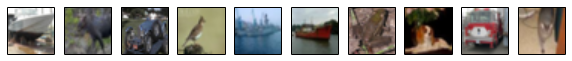

In [25]:

# https://people.cs.umass.edu/~jpjiang/cs646/03_eval_basics.pdf
def ap(retrieved, k):
    recall = 0
    tp = 0.0
    ap = 0.0

    for r in range(k):
        if retrieved[r]:
            tp += 1
            ap += tp / (r + 1)

    if tp > 0:
        return ap / tp
    
    return 0


with tf.device('/device:GPU:0'):
    batch_size = 200
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        saver.restore(session, "tmp_hash_30/model.ckpt")
        num_steps_per_epoch = test_retrieval_data.shape[0] / batch_size
        test_feats = []
        for step in range(num_steps_per_epoch):
            offset = step * batch_size
            batch_data_ref = test_retrieval_data[offset:(offset + batch_size), :, :, :]

            feed_dict = {tf_test_data: batch_data_ref,
                         keep_prob: 1.0, keep_prob2: 1.0, mode:'retrieval'}
            batch_feats = session.run(logits_test, feed_dict=feed_dict)
            test_feats.extend(batch_feats)
            print batch_feats.shape
        num_steps_per_epoch = train_data.shape[0] / batch_size
        train_feats = []
        for step in range(num_steps_per_epoch):
            offset = step * batch_size
            batch_data_ref = train_data[offset:(offset + batch_size), :, :, :]

            feed_dict = {tf_test_data: batch_data_ref,
                         keep_prob: 1.0, keep_prob2: 1.0, mode:'retrieval'}
            batch_feats = session.run(logits_test, feed_dict=feed_dict)
            train_feats.extend(batch_feats)

train_feats = np.array(train_feats)
test_feats = np.array(test_feats)

# from sklearn.metrics.pairwise import euclidean_distances
# D = euclidean_distances(test_feats, train_feats)

train_feats = train_feats >= 0.5
test_feats = test_feats >= 0.5



map = 0

D = np.zeros((test_feats.shape[0], train_feats.shape[0]))
for i in range(test_feats.shape[0]):
    for j in range(train_feats.shape[0]):
        D[i,j] = np.count_nonzero(test_feats[i,:] != train_feats[j,:])


for i in range(test_feats.shape[0]):
    d = D[i, :]
    order = np.argsort(d)
    match = train_labels_int[order] == test_retrieval_labels[i]
    ap_d = ap(match, 500)
    map += ap_d
        
map = map / test_feats.shape[0]
print("mAP : {}".format(map))

fig = plt.figure(figsize=(10,10))
for i in range(10):
    r = np.random.randint(test_feats.shape[0])
    img = test_retrieval_data[r, :, :, :]
    d = D[r, :]
    order = np.argsort(d)
    most_simil_imgs = train_data[order,:,:,:][0:10]
    ax = fig.add_subplot(1, 10, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(img)
#     for j in range(9):
#         ax = fig.add_subplot(10, 10, i*10 + j + 2)
#         im = most_simil_imgs[j,:,:,:]
#         ax.set_xticks([])
#         ax.set_yticks([])
#         plt.imshow(im)
            
plt.show()